## House Price Prediction using Linear, Ridge and Lasso Regression

The solution is divided into the following sections: 
- Data understanding and exploration
- Data cleaning
- Data preparation
- Model building and evaluation


### 1. Data Understanding and Exploration

Let's first have a look at the dataset and understand the size, attribute names etc.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# reading the dataset
housing = pd.read_csv("train.csv")

In [3]:
# summary of the dataset: 1460 rows, 80 columns, no null values
print(housing.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
# head
housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Understanding the Data Dictionary

The data dictionary contains the meaning of various attributes; some non-obvious ones are:

In [5]:

housing['MSSubClass'].astype('category').value_counts()

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64

In [6]:
# MSZoning: Identifies the general zoning classification of the sale.

housing['MSZoning'].astype('category').value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [7]:
# Street: Type of road access to property
housing['Street'].astype('category').value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64

In [8]:
# Alley: Type of alley access to property
housing['Alley'].astype('category').value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [9]:
# Utilities: Type of utilities available

housing['Utilities'].astype('category').value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

In [10]:
# LotShape: General shape of property

housing['LotShape'].astype('category').value_counts()

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

In [11]:
# LandContour: Flatness of the property

housing['LandContour'].astype('category').value_counts()

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

In [12]:
#LandSlope
housing['LandSlope'].astype('category').value_counts()

Gtl    1382
Mod      65
Sev      13
Name: LandSlope, dtype: int64

In [13]:
#Heating
housing['Heating'].astype('category').value_counts()

GasA     1428
GasW       18
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

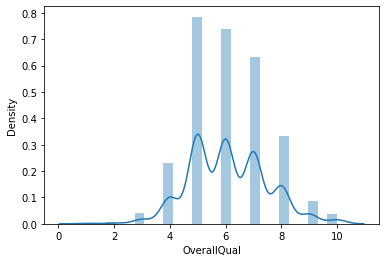

In [14]:
# OverallQual: Rates the overall material and finish of the house
sns.distplot(housing['OverallQual'])
plt.show()

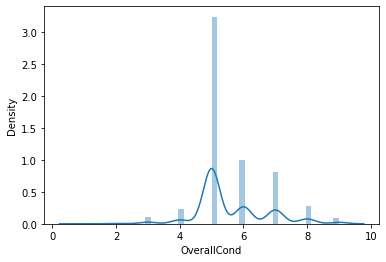

In [15]:
#OverallCond: Rates the overall condition of the house
sns.distplot(housing['OverallCond'])
plt.show()

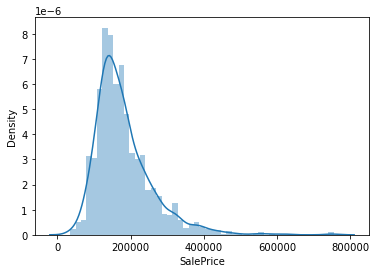

In [16]:
# target variable: price of house
sns.distplot(housing['SalePrice'])
plt.show()

#### Data Exploration

To perform linear regression, the (numeric) target variable should be linearly related to *at least one another numeric variable*. Let's see whether that's true in this case.


We'll first subset the list of all (independent) numeric variables, and then make a **pairwise plot**.

In [17]:
# all numeric (float and int) variables in the dataset
housing_numeric = housing.select_dtypes(include=['float64', 'int64'])
housing_numeric.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


In [18]:
housing_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   OverallQual    1460 non-null   int64  
 5   OverallCond    1460 non-null   int64  
 6   YearBuilt      1460 non-null   int64  
 7   YearRemodAdd   1460 non-null   int64  
 8   MasVnrArea     1452 non-null   float64
 9   BsmtFinSF1     1460 non-null   int64  
 10  BsmtFinSF2     1460 non-null   int64  
 11  BsmtUnfSF      1460 non-null   int64  
 12  TotalBsmtSF    1460 non-null   int64  
 13  1stFlrSF       1460 non-null   int64  
 14  2ndFlrSF       1460 non-null   int64  
 15  LowQualFinSF   1460 non-null   int64  
 16  GrLivArea      1460 non-null   int64  
 17  BsmtFullBath   1460 non-null   int64  
 18  BsmtHalf

This is quite hard to read, and we can rather plot correlations between variables. Also, a heatmap is pretty useful to visualise multiple correlations in one plot.

In [19]:
# correlation matrix
cor = housing_numeric.corr()
cor

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420


# 2. Data Cleaning

Let's now conduct some data cleaning steps. 



In [20]:
# variable formats
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [21]:
housing = housing.drop(['PoolQC','Fence','MiscFeature','FireplaceQu','Alley'], axis=1)

In [22]:
print(round(100*(housing.isnull().sum())/len(housing.index),2))

Id                0.00
MSSubClass        0.00
MSZoning          0.00
LotFrontage      17.74
LotArea           0.00
                 ...  
MoSold            0.00
YrSold            0.00
SaleType          0.00
SaleCondition     0.00
SalePrice         0.00
Length: 76, dtype: float64


In [23]:
column_with_nan = housing.columns[housing.isnull().any()]

In [24]:
for column in column_with_nan:
    print(column, round(100*(housing[column].isnull().sum())/len(housing.index),2))

LotFrontage 17.74
MasVnrType 0.55
MasVnrArea 0.55
BsmtQual 2.53
BsmtCond 2.53
BsmtExposure 2.6
BsmtFinType1 2.53
BsmtFinType2 2.6
Electrical 0.07
GarageType 5.55
GarageYrBlt 5.55
GarageFinish 5.55
GarageQual 5.55
GarageCond 5.55


In [25]:
housing = housing.drop(['LotFrontage'], axis=1)

In [26]:
# Neighorhood: first few entries
housing['Neighborhood'][:30]

0     CollgCr
1     Veenker
2     CollgCr
3     Crawfor
4     NoRidge
5     Mitchel
6     Somerst
7      NWAmes
8     OldTown
9     BrkSide
10     Sawyer
11    NridgHt
12     Sawyer
13    CollgCr
14      NAmes
15    BrkSide
16      NAmes
17     Sawyer
18    SawyerW
19      NAmes
20    NridgHt
21     IDOTRR
22    CollgCr
23    MeadowV
24     Sawyer
25    NridgHt
26      NAmes
27    NridgHt
28      NAmes
29    BrkSide
Name: Neighborhood, dtype: object

In [27]:
# outliers
housing.describe()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [28]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

In [29]:
# Drop the following columns that have more than 80% values associated to a specific value

# Method to get the column names that have count of one value more than 80%

def getHighValueCounts():
    column = []
    highvalue_columns = housing.select_dtypes(include=['object','int64','float64'])
    for col in (highvalue_columns):
        if(housing[col].value_counts().max() >= 1168):
            column.append(col)
    return column

columnsToBeRemoved = getHighValueCounts()

# Remove the columns with skewed data

housing.drop(columnsToBeRemoved, axis = 1, inplace = True)

housing.head(50)

,Id,MSSubClass,MSZoning,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,...,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold,SalePrice
0,1,60,RL,8450,Reg,Inside,CollgCr,2Story,7,5,...,Attchd,2003.0,RFn,2,548,0,61,2,2008,208500
1,2,20,RL,9600,Reg,FR2,Veenker,1Story,6,8,...,Attchd,1976.0,RFn,2,460,298,0,5,2007,181500
2,3,60,RL,11250,IR1,Inside,CollgCr,2Story,7,5,...,Attchd,2001.0,RFn,2,608,0,42,9,2008,223500
3,4,70,RL,9550,IR1,Corner,Crawfor,2Story,7,5,...,Detchd,1998.0,Unf,3,642,0,35,2,2006,140000
4,5,60,RL,14260,IR1,FR2,NoRidge,2Story,8,5,...,Attchd,2000.0,RFn,3,836,192,84,12,2008,250000
5,6,50,RL,14115,IR1,Inside,Mitchel,1.5Fin,5,5,...,Attchd,1993.0,Unf,2,480,40,30,10,2009,143000
6,7,20,RL,10084,Reg,Inside,Somerst,1Story,8,5,...,Attchd,2004.0,RFn,2,636,255,57,8,2007,307000
7,8,60,RL,10382,IR1,Corner,NWAmes,2Story,7,6,...,Attchd,1973.0,RFn,2,484,235,204,11,2009,200000
8,9,50,RM,6120,Reg,Inside,OldTown,1.5Fin,7,5,...,Detchd,1931.0,Unf,2,468,90,0,4,2008,129900
9,10,190,RL,7420,Reg,Corner,BrkSide,1.5Unf,5,6,...,Attchd,1939.0,RFn,1,205,0,4,1,2008,118000


In [30]:
# correlation matrix
cor1 = housing.corr()
cor

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,...,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,...,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,...,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,...,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,...,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,...,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,...,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,...,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,...,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,...,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420


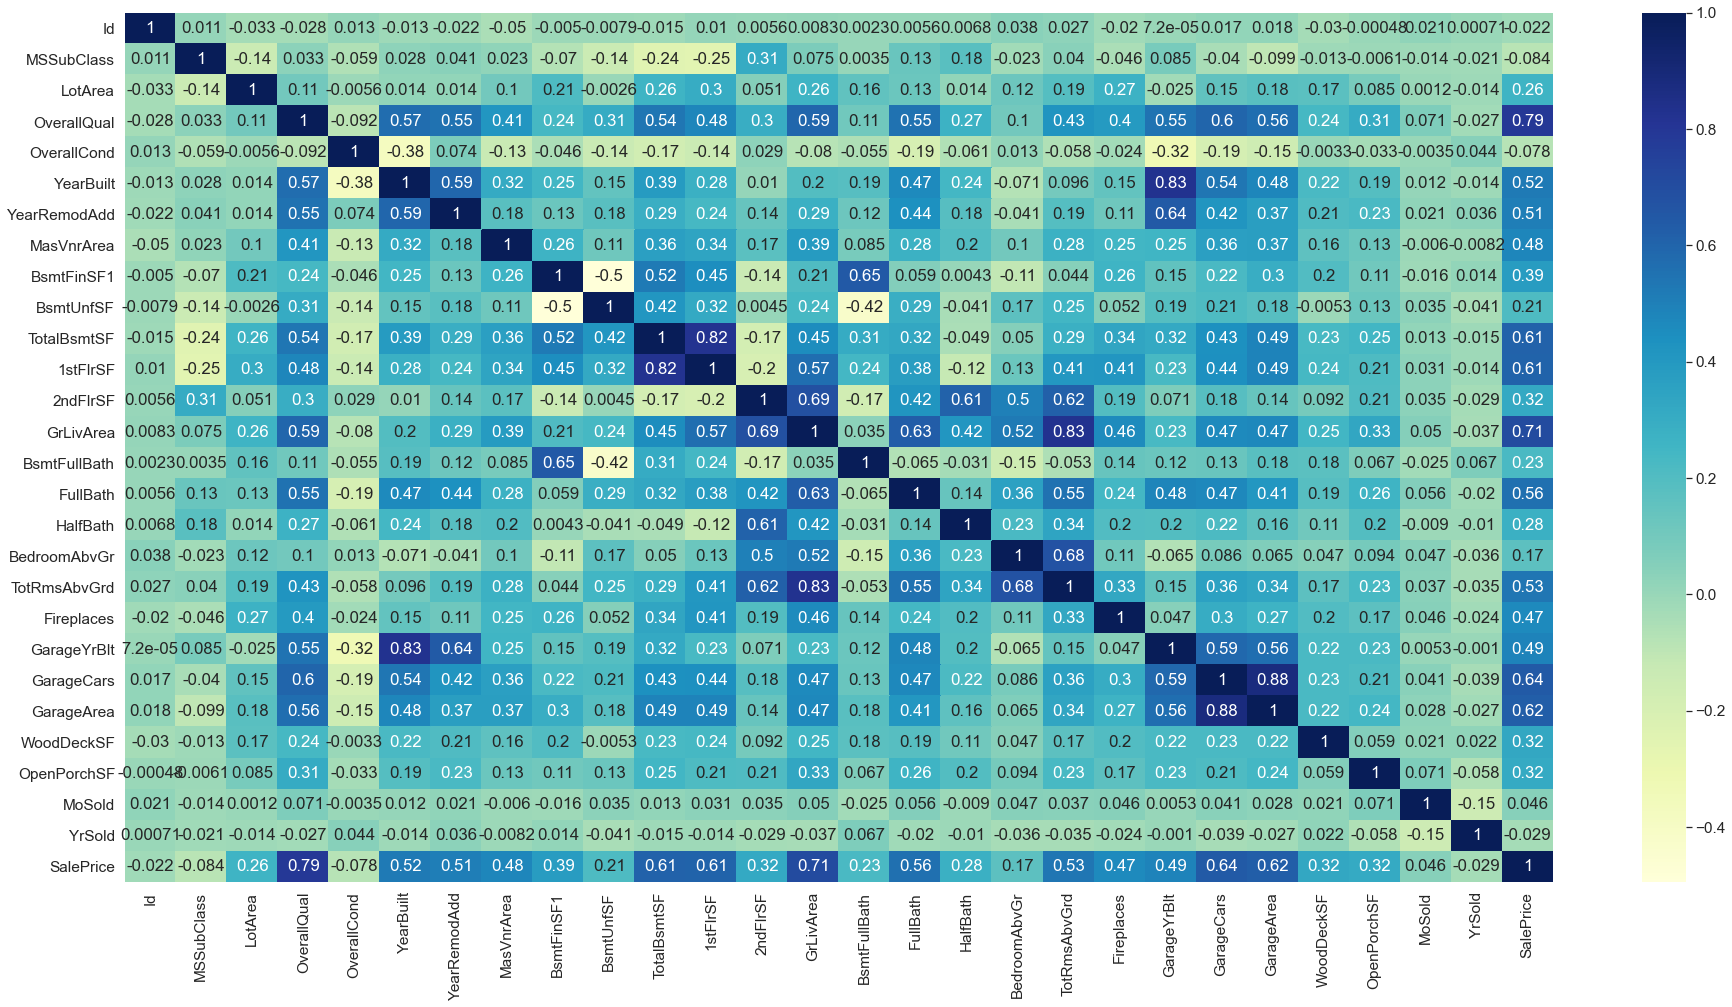

In [31]:
# plotting correlations on a heatmap

# figure size
plt.figure(figsize=(32,16))

sns.set(font_scale=1.4)

sns.heatmap(cor1, cmap="YlGnBu", annot=True)
plt.show()

In [32]:
#Dropping highly co-related variables TotRmsAbvGrd 83 % with GrLivArea and GarageArea 88% with GarageCars
#TotalBsmtSqft 82% with 1stFlrSF
#GarageYrBlt 83% with YearBuilt
# Removing the highly correlated variables

housing.drop(['TotRmsAbvGrd', 'GarageArea','GarageYrBlt','TotalBsmtSF','MasVnrType','Exterior2nd'], axis = 1, inplace = True)

In [33]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 40 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            1460 non-null   int64  
 1   MSSubClass    1460 non-null   int64  
 2   MSZoning      1460 non-null   object 
 3   LotArea       1460 non-null   int64  
 4   LotShape      1460 non-null   object 
 5   LotConfig     1460 non-null   object 
 6   Neighborhood  1460 non-null   object 
 7   HouseStyle    1460 non-null   object 
 8   OverallQual   1460 non-null   int64  
 9   OverallCond   1460 non-null   int64  
 10  YearBuilt     1460 non-null   int64  
 11  YearRemodAdd  1460 non-null   int64  
 12  RoofStyle     1460 non-null   object 
 13  Exterior1st   1460 non-null   object 
 14  MasVnrArea    1452 non-null   float64
 15  ExterQual     1460 non-null   object 
 16  Foundation    1460 non-null   object 
 17  BsmtQual      1423 non-null   object 
 18  BsmtExposure  1422 non-null 

In [34]:
housing.head(20)

,Id,MSSubClass,MSZoning,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,...,KitchenQual,Fireplaces,GarageType,GarageFinish,GarageCars,WoodDeckSF,OpenPorchSF,MoSold,YrSold,SalePrice
0,1,60,RL,8450,Reg,Inside,CollgCr,2Story,7,5,...,Gd,0,Attchd,RFn,2,0,61,2,2008,208500
1,2,20,RL,9600,Reg,FR2,Veenker,1Story,6,8,...,TA,1,Attchd,RFn,2,298,0,5,2007,181500
2,3,60,RL,11250,IR1,Inside,CollgCr,2Story,7,5,...,Gd,1,Attchd,RFn,2,0,42,9,2008,223500
3,4,70,RL,9550,IR1,Corner,Crawfor,2Story,7,5,...,Gd,1,Detchd,Unf,3,0,35,2,2006,140000
4,5,60,RL,14260,IR1,FR2,NoRidge,2Story,8,5,...,Gd,1,Attchd,RFn,3,192,84,12,2008,250000
5,6,50,RL,14115,IR1,Inside,Mitchel,1.5Fin,5,5,...,TA,0,Attchd,Unf,2,40,30,10,2009,143000
6,7,20,RL,10084,Reg,Inside,Somerst,1Story,8,5,...,Gd,1,Attchd,RFn,2,255,57,8,2007,307000
7,8,60,RL,10382,IR1,Corner,NWAmes,2Story,7,6,...,TA,2,Attchd,RFn,2,235,204,11,2009,200000
8,9,50,RM,6120,Reg,Inside,OldTown,1.5Fin,7,5,...,TA,2,Detchd,Unf,2,90,0,4,2008,129900
9,10,190,RL,7420,Reg,Corner,BrkSide,1.5Unf,5,6,...,TA,2,Attchd,RFn,1,0,4,1,2008,118000


## 3. Data Preparation 


#### Data Preparation

Let's now prepare the data and build the model.

In [35]:
# List of variables to map

varlist =  ['MSZoning', 'LotShape', 'LotConfig', 'HouseStyle','KitchenQual','GarageFinish',
            'GarageType','ExterQual','HeatingQC','BsmtQual','BsmtFinType1','BsmtExposure'
           ]

# Defining the map function
def binary_map(x):
    return x.map({'RL': 1, 'RM': 2, 'FV': 3,'RH':4,'C':5,'Reg': 1, 'IR1': 2, 'IR2': 3,'IR3':4,
                  'Inside': 5, 'Corner': 4, 'CulDSac': 3, 'FR2': 2, 'FR3': 1, 
                  'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0,
                  'SLvl': 8, 'SFoyer': 7, '2.5Fin': 6, '2.5Unf': 5, '2Story': 4,'1.5Fin': 3, '1.5Unf': 2, '1Story': 1,
                  'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 
                  'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0,
                  'Av': 3, 'Mn': 2, 'No': 1,
                  'Attchd':1,'Detchd':2,'BuiltIn':3,'CarPort':4
                 })

# Applying the function to the housing list
housing[varlist] = housing[varlist].apply(binary_map)
housing.head(25)
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 40 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            1460 non-null   int64  
 1   MSSubClass    1460 non-null   int64  
 2   MSZoning      1450 non-null   float64
 3   LotArea       1460 non-null   int64  
 4   LotShape      1460 non-null   int64  
 5   LotConfig     1460 non-null   int64  
 6   Neighborhood  1460 non-null   object 
 7   HouseStyle    1460 non-null   int64  
 8   OverallQual   1460 non-null   int64  
 9   OverallCond   1460 non-null   int64  
 10  YearBuilt     1460 non-null   int64  
 11  YearRemodAdd  1460 non-null   int64  
 12  RoofStyle     1460 non-null   object 
 13  Exterior1st   1460 non-null   object 
 14  MasVnrArea    1452 non-null   float64
 15  ExterQual     1460 non-null   int64  
 16  Foundation    1460 non-null   object 
 17  BsmtQual      1423 non-null   float64
 18  BsmtExposure  1422 non-null 

In [36]:
# creating dummy variables for categorical variables

# subset all categorical variables
#housing_categorical = X.select_dtypes(include=['object'])
#housing_categorical.head()


In [37]:
# convert into dummies - one hot encoding
neigh_dummies = pd.get_dummies(housing['Neighborhood'], drop_first=True)
neigh_dummies.head()

,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,...,NoRidge,NridgHt,OldTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [38]:
# concat dummy variables with housing
housing = pd.concat([housing, neigh_dummies], axis=1)

In [39]:
# convert into dummies - one hot encoding
roof_dummies = pd.get_dummies(housing['RoofStyle'], drop_first=True)
roof_dummies.head()

,Gable,Gambrel,Hip,Mansard,Shed
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [40]:
# concat dummy variables with housing
housing = pd.concat([housing, roof_dummies], axis=1)

In [41]:
# convert into dummies - one hot encoding
ext1_dummies = pd.get_dummies(housing['Exterior1st'], drop_first=True)
ext1_dummies.head()

,AsphShn,BrkComm,BrkFace,CBlock,CemntBd,HdBoard,ImStucc,MetalSd,Plywood,Stone,Stucco,VinylSd,Wd Sdng,WdShing
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [42]:
# concat dummy variables with housing
housing = pd.concat([housing, ext1_dummies], axis=1)

In [43]:
# convert into dummies - one hot encoding
fond_dummies = pd.get_dummies(housing['Foundation'], drop_first=True)
fond_dummies.head()

,CBlock,PConc,Slab,Stone,Wood
0,0,1,0,0,0
1,1,0,0,0,0
2,0,1,0,0,0
3,0,0,0,0,0
4,0,1,0,0,0


In [44]:
# concat dummy variables with housing
housing = pd.concat([housing, fond_dummies], axis=1)

In [45]:
# drop categorical variables 
housing.drop(['Neighborhood','RoofStyle','Exterior1st','Foundation'], axis=1,inplace = True)

In [46]:
housing.head()

,Id,MSSubClass,MSZoning,LotArea,LotShape,LotConfig,HouseStyle,OverallQual,OverallCond,YearBuilt,...,Stone,Stucco,VinylSd,Wd Sdng,WdShing,CBlock,PConc,Slab,Stone,Wood
0,1,60,1.0,8450,1,5,4,7,5,2003,...,0,0,1,0,0,0,1,0,0,0
1,2,20,1.0,9600,1,2,1,6,8,1976,...,0,0,0,0,0,1,0,0,0,0
2,3,60,1.0,11250,2,5,4,7,5,2001,...,0,0,1,0,0,0,1,0,0,0
3,4,70,1.0,9550,2,4,4,7,5,1915,...,0,0,0,1,0,0,0,0,0,0
4,5,60,1.0,14260,2,2,4,8,5,2000,...,0,0,1,0,0,0,1,0,0,0


In [47]:
# Checking outliers at 25%,50%,75%,90%,95% and above

housing.describe(percentiles=[.25,.5,.75,.90,.95,.99])



,Id,MSSubClass,MSZoning,LotArea,LotShape,LotConfig,HouseStyle,OverallQual,OverallCond,YearBuilt,...,Stone,Stucco,VinylSd,Wd Sdng,WdShing,CBlock,PConc,Slab,Stone,Wood
count,1460.000000,1460.000000,1450.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,1.273103,10516.828082,1.408219,4.583562,2.656164,6.099315,5.575342,1971.267808,...,0.001370,0.017123,0.352740,0.141096,0.017808,0.434247,0.443151,0.016438,0.004110,0.002055
std,421.610009,42.300571,0.595504,9981.264932,0.582296,0.773448,1.945698,1.382997,1.112799,30.202904,...,0.036999,0.129775,0.477986,0.348240,0.132299,0.495827,0.496928,0.127198,0.063996,0.045299
min,1.000000,20.000000,1.000000,1300.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1872.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,365.750000,20.000000,1.000000,7553.500000,1.000000,4.000000,1.000000,5.000000,5.000000,1954.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,730.500000,50.000000,1.000000,9478.500000,1.000000,5.000000,2.000000,6.000000,5.000000,1973.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1095.250000,70.000000,1.000000,11601.500000,2.000000,5.000000,4.000000,7.000000,6.000000,2000.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
90%,1314.100000,120.000000,2.000000,14381.700000,2.000000,5.000000,4.000000,8.000000,7.000000,2006.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
95%,1387.050000,160.000000,3.000000,17401.150000,2.000000,5.000000,7.000000,8.000000,8.000000,2007.000000,...,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
99%,1445.410000,190.000000,4.000000,37567.640000,3.000000,5.000000,8.000000,10.000000,9.000000,2009.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000


In [48]:
# Removing Outliers

# Removing values beyond 98% for LotArea

nn_quartile_LotArea = housing['LotArea'].quantile(0.98)
housing = housing[housing["LotArea"] < nn_quartile_LotArea]

In [49]:
# check the null values in the numerical data

housing.select_dtypes(include=['int64','float64']).isnull().sum()[housing.select_dtypes(include=['int64','float64']).isnull()
                                                                  .sum()>0]

MSZoning         10
MasVnrArea        7
BsmtQual         37
BsmtExposure     38
BsmtFinType1     37
GarageType      104
GarageFinish     81
dtype: int64

In [50]:

# Impute the null values with median values for columns

housing['MSZoning'] = housing['MSZoning'].replace(np.nan, housing['MSZoning'].median())
housing['MasVnrArea'] = housing['MasVnrArea'].replace(np.nan, housing['MasVnrArea'].median())
housing['BsmtQual'] = housing['BsmtQual'].replace(np.nan, housing['BsmtQual'].median())
housing['BsmtExposure'] = housing['BsmtExposure'].replace(np.nan, housing['BsmtExposure'].median())
housing['BsmtFinType1'] = housing['BsmtFinType1'].replace(np.nan, housing['BsmtFinType1'].median())
housing['GarageType'] = housing['GarageType'].replace(np.nan, housing['GarageType'].median())
housing['GarageFinish'] = housing['GarageFinish'].replace(np.nan, housing['GarageFinish'].median())

In [51]:
# Putting all feature variable to X

X = housing.drop(['SalePrice'], axis=1)
X.head()
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1430 entries, 0 to 1459
Data columns (total 83 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            1430 non-null   int64  
 1   MSSubClass    1430 non-null   int64  
 2   MSZoning      1430 non-null   float64
 3   LotArea       1430 non-null   int64  
 4   LotShape      1430 non-null   int64  
 5   LotConfig     1430 non-null   int64  
 6   HouseStyle    1430 non-null   int64  
 7   OverallQual   1430 non-null   int64  
 8   OverallCond   1430 non-null   int64  
 9   YearBuilt     1430 non-null   int64  
 10  YearRemodAdd  1430 non-null   int64  
 11  MasVnrArea    1430 non-null   float64
 12  ExterQual     1430 non-null   int64  
 13  BsmtQual      1430 non-null   float64
 14  BsmtExposure  1430 non-null   float64
 15  BsmtFinType1  1430 non-null   float64
 16  BsmtFinSF1    1430 non-null   int64  
 17  BsmtUnfSF     1430 non-null   int64  
 18  HeatingQC     1430 non-null 

In [52]:

# Putting response variable to y

y = housing['SalePrice']
y.head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

In [53]:
# scaling the features - necessary before using Ridge or Lasso
from sklearn.preprocessing import scale

# storing column names in cols, since column names are (annoyingly) lost after 
# scaling (the df is converted to a numpy array)
cols = X.columns
X = pd.DataFrame(scale(X))
X.columns = cols
X.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'LotShape', 'LotConfig',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'ExterQual', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinSF1', 'BsmtUnfSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenQual', 'Fireplaces', 'GarageType', 'GarageFinish', 'GarageCars',
       'WoodDeckSF', 'OpenPorchSF', 'MoSold', 'YrSold', 'Blueste', 'BrDale',
       'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert',
       'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NPkVill', 'NWAmes', 'NoRidge',
       'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst',
       'StoneBr', 'Timber', 'Veenker', 'Gable', 'Gambrel', 'Hip', 'Mansard',
       'Shed', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'CemntBd', 'HdBoard',
       'ImStucc', 'MetalSd', 'Plywood', 'Stone', 'Stucco', 'VinylSd',
       'Wd Sd

In [54]:
# split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

## 3. Model Building and Evaluation

## Linear Regression

Let's now try predicting house prices, a dataset using linear regression.

In [55]:
# Instantiate
lm = LinearRegression()

# Fit a line
lm.fit(X_train, y_train)

LinearRegression()

In [56]:
# Print the coefficients and intercept
print(lm.intercept_)
print(lm.coef_)

180027.03452124572
[ 1.25290701e+02 -8.46428347e+03 -2.44266587e+02  6.74309625e+03
 -2.45137195e+02  6.79619471e+02 -1.52675500e+02  1.29914978e+04
  7.03069932e+03  7.11674751e+03  2.58081398e+02  2.17446693e+03
  3.68911394e+03  4.85262180e+03  7.65839464e+03 -3.85554455e+02
  1.40870475e+04  5.81379579e+03  6.95601392e+02 -4.80007425e+03
 -2.96336212e+03  3.84797354e+04  5.25493492e+02 -1.11106003e+02
 -6.37562956e+02 -4.07268501e+03  4.78944278e+03  6.29036382e+02
  1.94619128e+03  8.55742247e+02  2.94251768e+03  9.47605175e+02
  1.73948652e+03 -1.42110832e+03 -3.09777600e+02  6.84580373e+02
  1.28073757e+03  1.92654200e+03 -1.27334891e+03 -1.10927695e+03
  2.70100989e+03 -1.27209499e+03 -1.11261299e+03 -3.77815179e+02
  7.10867918e+02 -1.41190627e+03 -4.24492832e+02  2.08974130e+03
 -1.93668705e+03  4.34181142e+03  8.87975726e+03 -1.85380110e+03
 -1.17851448e+03 -1.46991966e+02 -7.33295308e+02  2.79458613e+03
  6.72935966e+03 -1.41128059e+02  7.34420121e+02  1.01867950e+04
  2.62

In [57]:
from sklearn.metrics import r2_score, mean_squared_error

In [58]:
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

metric = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric.append(mse_test_lr**0.5)

0.9020279224110653
0.8881393179058248
598511263837.6631
283096216204.1561
598511263.837663
659897939.8698277


## Ridge and Lasso Regression

Let's now try predicting car prices, a dataset used in simple linear regression, to perform ridge and lasso regression.

## Ridge Regression

In [59]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 
#https://scikit-learn.org/stable/modules/model_evaluation.html

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    2.4s finished


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [60]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 500}


In [73]:
#Fitting Ridge model for alpha = 500 and printing coefficients which have been penalised
alpha = 500
ridge = Ridge(alpha=alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[ -155.14329646 -4098.51093278  -809.37982705  5816.04029821
   457.76768082   827.03774097   253.88720812  9482.56547181
  3310.53435614  2228.58478505  2131.63836179  3786.1740735
  5263.14618187  4811.74407742  5195.94988721  1483.49579636
  6900.64237093  2223.1261412   1847.4890327   8212.66570724
  5841.54692018 11312.54768239  1472.45272565  3723.17142633
  2363.55729599   809.62682089  5744.46848896  3790.06551853
  1235.74012968  1993.35592351  4781.82557529  1847.94842935
  2335.94563388  -460.89617335  -461.68089648   103.3246764
    16.06140953   818.65288538  -442.44935479 -1256.09662267
  2145.96250074 -1851.80301342 -1920.06343754  -602.75748096
 -1014.60552253 -1165.29161584  -975.00231298   507.47118219
 -1111.30732316  4287.2721314   5816.57918411 -1406.33647837
  -909.44266616  -919.8259127   -981.18193637  1061.5523629
  4293.62697585   -42.30569733   400.19585692 -1207.75933728
   244.13680629  1746.73871365   -71.02681201  -309.38408693
  -626.38383029  -878.28541

In [74]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

metric2 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.8814085789649619
0.894360234303091
724474799664.773
267352365367.40036
724474799.664773
623198986.8703971


## Lasso

In [75]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:   29.3s finished


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [76]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 500}


In [77]:
#Fitting Lasso model for alpha = 500 and printing coefficients which have been penalised

alpha =500

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=500)

In [78]:
lasso.coef_

array([ 0.00000000e+00, -7.42012843e+03, -0.00000000e+00,  5.01755433e+03,
        0.00000000e+00,  8.10675840e+01, -0.00000000e+00,  1.37200301e+04,
        5.86272412e+03,  4.93910720e+03,  8.55758725e+01,  2.25543394e+03,
        4.37532931e+03,  4.96823625e+03,  6.94567210e+03,  0.00000000e+00,
        1.22759870e+04,  3.79200637e+03,  5.01580357e+02,  0.00000000e+00,
        0.00000000e+00,  3.26686153e+04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -2.70879925e+03,  5.53327745e+03,  5.87302074e+02,
        1.09581273e+03,  8.88626247e+02,  3.60727923e+03,  7.48904024e+02,
        1.21178141e+03, -6.61068634e+02, -0.00000000e+00,  2.16711012e+02,
        4.05983712e+02,  1.57562610e+03, -5.69086292e+02, -0.00000000e+00,
        2.65236605e+03, -4.69170369e+02, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -3.59356449e+02,  0.00000000e+00,  1.07342166e+03,
       -9.22185387e+02,  4.47319389e+03,  9.11306763e+03, -1.12369661e+03,
       -7.13268783e+02,  

In [79]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

metric3 = []
r2_train_lr = r2_score(y_train, y_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_train - y_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_train, y_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.8990728868014316
0.8926741334997936
616563571606.6971
271619537251.35526
616563571.6066972
633145774.4786836


In [80]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),9.020279e-01,8.814086e-01,8.990729e-01
1,R2 Score (Test),8.881393e-01,8.943602e-01,8.926741e-01
2,RSS (Train),5.985113e+11,7.244748e+11,6.165636e+11
3,RSS (Test),2.830962e+11,2.673524e+11,2.716195e+11
4,MSE (Train),2.446449e+04,2.691607e+04,2.483070e+04
5,MSE (Test),2.568848e+04,2.496395e+04,2.516239e+04


## Lets observe the changes in the coefficients after regularization

In [81]:
betas = pd.DataFrame(index=X.columns)

In [82]:
betas.rows = X.columns

In [83]:
betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_

In [84]:
pd.set_option('display.max_rows', None)
betas.head(68)

,Linear,Ridge,Lasso
Id,125.290701,-155.143296,0.000000
MSSubClass,-8464.283471,-4098.510933,-7420.128427
MSZoning,-244.266587,-809.379827,-0.000000
LotArea,6743.096252,5816.040298,5017.554329
LotShape,-245.137195,457.767681,0.000000
LotConfig,679.619471,827.037741,81.067584
HouseStyle,-152.675500,253.887208,-0.000000
OverallQual,12991.497826,9482.565472,13720.030109
OverallCond,7030.699317,3310.534356,5862.724116
YearBuilt,7116.747508,2228.584785,4939.107198
